In [1]:
# Importing libraries and setting the dataset to a dataframe by reading the csv. 
# Sets the datatype of Customer ID and Invoice Id to string
# Code and the description of what this code is doing has been taken from the sources below. 
# Some code has been modified.

#https://www.kaggle.com/fabiendaniel/customer-segmentation/notebook
#https://towardsdatascience.com/how-to-create-a-production-ready-recommender-system-3c932752f8ea
#https://www.kaggle.com/povilass/analysis-of-transactions-from-a-bakery-and-apriori/data
#https://medium.com/edureka/apriori-algorithm-d7cc648d4f1e
#https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/
#https://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array
#https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import warnings 
warnings.filterwarnings('ignore') # never print matching warnings
import seaborn as sns # Advanced data visualization
import datetime# module supplies classes for manipulating dates and times
import matplotlib.pyplot as plt # Data visualization
from mlxtend.frequent_patterns import apriori # Data pattern exploration
from mlxtend.frequent_patterns import association_rules # Association rules conversion
from scipy.sparse import lil_matrix # Row-based list of lists sparse matrix
%matplotlib inline 
hybridSystemData = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})



In [2]:
# Data Preparation

In [3]:
# The sum of how many values in the dataframe are null
hybridSystemData.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# looking at the top 5 countries where transactions were made and finding how many transactions were made in that country
hybridSystemData.Country.value_counts().head(5)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [5]:
# Extracting all rows that contain transactions for the United Kingdom and all quantities that have values greater than 0. 
# This is because some of the quantities are returns and have negative values.Taking subset of the dataset
hybridSystemData = hybridSystemData[hybridSystemData.Country == 'United Kingdom']
hybridSystemData = hybridSystemData[hybridSystemData.Quantity >0]

In [6]:
# Looking at the shape of the dataset
print(hybridSystemData.shape)
# Checking the count of uniques values 
print(hybridSystemData.Country.value_counts().head(5))

(486286, 8)
United Kingdom    486286
Name: Country, dtype: int64


In [7]:
# Outputting the unique values in the Description column
hybridSystemData['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'CREAM HANGING HEART T-LIGHT HOLDER',
       "BLACK SIL'T SQU CANDLE PLATE ", 'PAPER CRAFT , LITTLE BIRDIE'],
      dtype=object)

In [8]:
# Dropping all null values in the CustomerID column
hybridSystemData.dropna(axis = 0, subset = ['CustomerID'], inplace = True)


In [9]:
# Checking how many duplicate entries are in the dataset, then dropping these.
print('Duplicate Entries: {}'.format(hybridSystemData.duplicated().sum()))
hybridSystemData.drop_duplicates(inplace = True)
# Looking at the shape of the dataset after nulls and duplicate values have been dropped
hybridSystemData.shape

Duplicate Entries: 5118


(349227, 8)

In [10]:
# Looking at the information on the dataset
hybridSystemData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      349227 non-null object
StockCode      349227 non-null object
Description    349227 non-null object
Quantity       349227 non-null int64
InvoiceDate    349227 non-null object
UnitPrice      349227 non-null float64
CustomerID     349227 non-null object
Country        349227 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 24.0+ MB


In [11]:
# Getting only the first 20 transactions of each customer as the dataset is very big and may be easier to work with. 
# Assigning it to a new dataframe.
hybridSystemData_CustomerIDLimit = pd.DataFrame(hybridSystemData.groupby(['CustomerID']).head(20))
hybridSystemData_CustomerIDLimit.shape

(66859, 8)

In [12]:
# Creating new array for invoices and description and assigning only uniques values in those columns to these
invoices = hybridSystemData['InvoiceNo'].unique()
description = hybridSystemData['Description'].unique()
print(invoices.shape)
print(description.shape)

(16649,)
(3844,)


In [13]:
# Output the description to a file for use later by the recommender system.
# The csv was created for testing purposes so I could see in a clearer format what the index of an item is.
pd.DataFrame(description).to_csv("descriptionArray.csv")

In [14]:
# O base indexing both the invoives and description as the id values are quite big
# This indexing can be used for the Apriori algorithm but it would require the oputput to be convertyed back from item index description to the description
# This is the process completed in the recommender system
hybridSystemData_CustomerIDLimit['invoices'] = hybridSystemData_CustomerIDLimit['InvoiceNo'].apply(lambda x : np.argwhere(invoices == x)[0][0])
hybridSystemData_CustomerIDLimit['description'] = hybridSystemData_CustomerIDLimit['Description'].apply(lambda x : np.argwhere(description == x)[0][0])

In [15]:
# Data visualizations

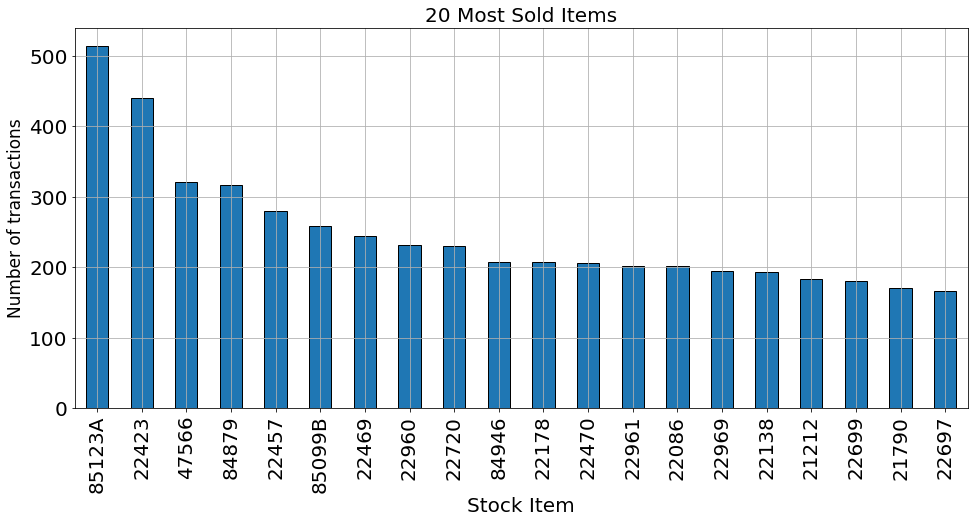

In [16]:
# Plot of the 20 most sold items
fig, ax=plt.subplots(figsize=(16,7))
hybridSystemData_CustomerIDLimit['StockCode'].value_counts().sort_values(ascending=False).head(20).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=1)
plt.xlabel('Stock Item',fontsize=20)
plt.ylabel('Number of transactions',fontsize=17)
ax.tick_params(labelsize=20)
plt.title('20 Most Sold Items',fontsize=20)
plt.grid()
plt.ioff()

In [17]:
# Using the datetime library to break up the Invoice date for visualisation purposes
hybridSystemData_CustomerIDLimit['InvoiceDate'] = pd.to_datetime(hybridSystemData_CustomerIDLimit['InvoiceDate'])
hybridSystemData_CustomerIDLimit['Week'] = hybridSystemData_CustomerIDLimit['InvoiceDate'].dt.week
hybridSystemData_CustomerIDLimit['Month'] = hybridSystemData_CustomerIDLimit['InvoiceDate'].dt.month
hybridSystemData_CustomerIDLimit['Weekday'] = hybridSystemData_CustomerIDLimit['InvoiceDate'].dt.weekday
hybridSystemData_CustomerIDLimit['Hours'] = hybridSystemData_CustomerIDLimit['InvoiceDate'].dt.hour

In [18]:
# Outputting the data now assigned using the datetime library
hybridSystemData_CustomerIDLimit[['InvoiceDate','InvoiceNo', 'Month','Week', 'Weekday','Hours']]

,InvoiceDate,InvoiceNo,Month,Week,Weekday,Hours
0,2010-12-01 08:26:00,536365,12,48,2,8
1,2010-12-01 08:26:00,536365,12,48,2,8
2,2010-12-01 08:26:00,536365,12,48,2,8
3,2010-12-01 08:26:00,536365,12,48,2,8
4,2010-12-01 08:26:00,536365,12,48,2,8
...,...,...,...,...,...,...
540074,2011-12-08 18:51:00,581461,12,49,3,18
540075,2011-12-08 18:51:00,581461,12,49,3,18
540076,2011-12-08 18:51:00,581461,12,49,3,18
540077,2011-12-08 18:51:00,581461,12,49,3,18


In [19]:
# Assigning this datetime dataframe to a new dataframe
df1=pd.DataFrame(hybridSystemData_CustomerIDLimit[['InvoiceDate','InvoiceNo', 'Month','Week', 'Weekday','Hours']])

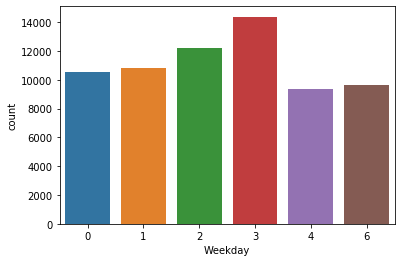

In [20]:
# A visualisation of the count of items purchased on each day of the week
sns.countplot(x='Weekday',data=df1)

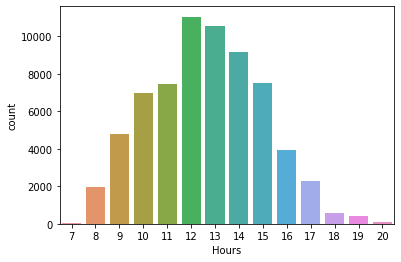

In [21]:
# A visualisatin of the count of items purcahsed during the hours of the day
sns.countplot(x='Hours',data=df1)

In [22]:
# Evaluate Output of Both Systems

In [23]:
#################### APRIORI SYSTEM ######################

In [24]:
# Assigning the dataframe to a new dataframe
aprioriData = pd.DataFrame(hybridSystemData_CustomerIDLimit)

In [25]:
# A basket was created to store invoice number and description with all positive values converted to 1 and any values less than 0 are set to 0. 
basket = (aprioriData.groupby(['InvoiceNo', 'Description'])['Description']
        .count().unstack().reset_index().fillna(0)
        .set_index('InvoiceNo'))
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,...,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# As there are alot of zeros in the data but we also need to make sure that any data that is greater than 0 is converted to 1
# Any item not purchased in the invoice is set to 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
basket_sets

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,...,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# We generate frequent basket sets that have support value greater than 0.016%. 
# This support can be lowered to return more products if needed (0.010 will output 26 values for the receommender system)
frequent_itemsets = apriori(basket_sets, min_support=0.016, use_colnames=True)

In [28]:
# We are now able to create rules with corresponding support, confidence and lift 
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.019473,0.026837,0.016037,0.823529,30.686514,0.015514,5.514591
1,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.026837,0.019473,0.016037,0.597561,30.686514,0.015514,2.436461
2,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.029455,0.026837,0.018982,0.644444,24.013415,0.018192,2.737021
3,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.026837,0.029455,0.018982,0.707317,24.013415,0.018192,3.316028
4,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.039764,0.033546,0.016364,0.411523,12.267389,0.015030,1.642296
5,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.033546,0.039764,0.016364,0.487805,12.267389,0.015030,1.874746


In [29]:
# Filter the dataframe using standard pandas code, for a large lift (6) and high confidence (.8)
rules[(rules['lift'] >= 6) & (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.019473,0.026837,0.016037,0.823529,30.686514,0.015514,5.514591


In [30]:
# An array was created to store the first item in the rule for use later by the recommender system
# The items that can be confidently predicted to be bought together are outputted.
aprioriArray= []
for item in rules.values.tolist():

    pair0 = item[0] 
    items0 = [x for x in pair0]
    pair1 = item[1] 
    items1 = [x for x in pair1]
    aprioriArray.append(items0[0])
    print("Item: " + str(items0[0]) + " -> " + str(items1[0]))
    print("Support: " + str(item[4]))
    print("Confidence: " + str(item[5]))
    print("Lift: " + str(item[6]))
    print("=====================================")

Item: PINK REGENCY TEACUP AND SAUCER -> GREEN REGENCY TEACUP AND SAUCER
Support: 0.016036655211912942
Confidence: 0.8235294117647058
Lift: 30.68651362984218
Item: GREEN REGENCY TEACUP AND SAUCER -> PINK REGENCY TEACUP AND SAUCER
Support: 0.016036655211912942
Confidence: 0.5975609756097561
Lift: 30.686513629842178
Item: ROSES REGENCY TEACUP AND SAUCER  -> GREEN REGENCY TEACUP AND SAUCER
Support: 0.018982163312060218
Confidence: 0.6444444444444444
Lift: 24.01341463414634
Item: GREEN REGENCY TEACUP AND SAUCER -> ROSES REGENCY TEACUP AND SAUCER 
Support: 0.018982163312060218
Confidence: 0.7073170731707317
Lift: 24.01341463414634
Item: HEART OF WICKER SMALL -> HEART OF WICKER LARGE
Support: 0.016363933889707086
Confidence: 0.41152263374485604
Lift: 12.267389340560074
Item: HEART OF WICKER LARGE -> HEART OF WICKER SMALL
Support: 0.016363933889707086
Confidence: 0.48780487804878053
Lift: 12.267389340560074


In [31]:
#Outputing the value in the array
print(aprioriArray)

['PINK REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER', 'HEART OF WICKER SMALL', 'HEART OF WICKER LARGE']


In [32]:
# Reading in the values from the csv file of item descriptions created earlier
descriptionCSVData = pd.read_csv('descriptionArray.csv')

# Setting column names in the dataframe
descriptionCSVData.columns = ['baseIndex', 'baseDesc']

In [33]:
# Output the dataframe
descriptionCSVData.head(10)

,baseIndex,baseDesc
0,0,WHITE HANGING HEART T-LIGHT HOLDER
1,1,WHITE METAL LANTERN
2,2,CREAM CUPID HEARTS COAT HANGER
3,3,KNITTED UNION FLAG HOT WATER BOTTLE
4,4,RED WOOLLY HOTTIE WHITE HEART.
5,5,SET 7 BABUSHKA NESTING BOXES
6,6,GLASS STAR FROSTED T-LIGHT HOLDER
7,7,HAND WARMER UNION JACK
8,8,HAND WARMER RED POLKA DOT
9,9,ASSORTED COLOUR BIRD ORNAMENT


In [34]:
# Creating an array of item numbers for use in the comparison with the LLR output
aprioriNumbers = []

for i in np.unique(aprioriArray):
    # Output the  description of the item
    print(i)
    aprioriNumbers.append(np.where(descriptionCSVData['baseDesc'].str.contains(i))[0][0])
# Output the  indexes of the items in the numbers array
print(aprioriNumbers)

GREEN REGENCY TEACUP AND SAUCER
HEART OF WICKER LARGE
HEART OF WICKER SMALL
PINK REGENCY TEACUP AND SAUCER
ROSES REGENCY TEACUP AND SAUCER 
[607, 109, 108, 1906, 602]


In [35]:
#################### RECOMMENDER SYSTEM ######################

In [36]:
# Creating a new dataframe
recData = pd.DataFrame(hybridSystemData_CustomerIDLimit)

In [37]:
# An occurrence lil_matrix is made from the values that are greater than 0 and this matrix is assigned with values from invoices and description columns
occurences = lil_matrix((invoices.shape[0], description.shape[0]), dtype='int8')
def set_occurences(invoice, description):
    occurences[invoice, description] += 1
recData.apply(lambda row: set_occurences(row['invoices'], row['description']), axis=1)
occurences

<16649x3844 sparse matrix of type '<class 'numpy.int8'>'
	with 66474 stored elements in LInked List format>

In [38]:
# A co-occurrence matrix is created from the occurrence matrix
cooc = occurences.transpose().dot(occurences)
cooc.setdiag(0)

In [39]:
# The LLR algorithm used for the recommender system. This algorithm was proposed by Ted Dunning 
# The LLR computes the likelihood of two events, A and B appear together.

# The parameters are

#     k11, number of when both events appeared together
#     k12, number of B appear without A
#     k21, number of A appear without B
#     k22, number of other things appeared without both of them
def xLogX(x):
    return x * np.log(x) if x != 0 else 0.0
def entropy(x1, x2=0, x3=0, x4=0):
    return xLogX(x1 + x2 + x3 + x4) - xLogX(x1) - xLogX(x2) - xLogX(x3) - xLogX(x4)
def LLR(k11, k12, k21, k22):
    rowEntropy = entropy(k11 + k12, k21 + k22)
    columnEntropy = entropy(k11 + k21, k12 + k22)
    matrixEntropy = entropy(k11, k12, k21, k22)
    if rowEntropy + columnEntropy < matrixEntropy:
        return 0.0
    return 2.0 * (rowEntropy + columnEntropy - matrixEntropy)
def rootLLR(k11, k12, k21, k22):
    llr = LLR(k11, k12, k21, k22)
    sqrt = np.sqrt(llr)
    if k11 * 1.0 / (k11 + k12) < k21 * 1.0 / (k21 + k22):
        sqrt = -sqrt
    return sqrt

In [40]:
# The LLR is calculated for items and is saved to a pp_score matrix
row_sum = np.sum(cooc, axis=0).A.flatten()
column_sum = np.sum(cooc, axis=1).A.flatten()
total = np.sum(row_sum, axis=0)
pp_score = lil_matrix((cooc.shape[0], cooc.shape[1]), dtype='double')
cx = cooc.tocoo()
for i,j,v in zip(cx.row, cx.col, cx.data):
    if v != 0:
        k11 = v
        k12 = row_sum[i] - k11
        k21 = column_sum[j] - k11
        k22 = total - k11 - k12 - k21
        pp_score[i,j] = rootLLR(k11, k12, k21, k22)

In [41]:
# The results are sorted so that the highest LLR score on each item is on the first column of each row. 
result = np.flip(np.sort(pp_score.A, axis=1), axis=1)
result_indices = np.flip(np.argsort(pp_score.A, axis=1), axis=1)

In [42]:
# A minimum LLR score is given to remove insignificant indicators
minLLR = 5
indicators = result[:, :50]
indicators[indicators < minLLR] = 0.0
indicators_indices = result_indices[:, :50]
max_indicator_indices = (indicators==0).argmax(axis=1)
max = max_indicator_indices.max()
indicators = indicators[:, :max+1]
indicators_indices = indicators_indices[:, :max+1]

In [43]:
# An example of the indicators would be the score of item 1906(GREEN REGENCY TEACUP AND SAUCER).
# The indicators for this are the items that are most likely to be bought together.
# The higher the LLR score the mor likely they are to be bought together
print(indicators[1906])

[22.31514426 18.88515034 12.64815509  9.17658448  8.99863889  6.86232726
  5.81920863  5.59802952  5.25591637  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [44]:
# The description of the items  seen in the previous output
# ROSES REGENCY TEACUP AND SAUCER has the highest LLR score so is the first item in the list of indicators
description[indicators_indices[1906, :indicators[1906].nonzero()[0].shape[0]]].astype("str").tolist()

['GREEN REGENCY TEACUP AND SAUCER',
 'ROSES REGENCY TEACUP AND SAUCER ',
 'REGENCY CAKESTAND 3 TIER',
 'REGENCY TEA PLATE GREEN ',
 'REGENCY TEA PLATE PINK',
 'REGENCY TEA PLATE ROSES ',
 'REGENCY SUGAR BOWL GREEN',
 'REGENCY TEAPOT ROSES ',
 'SET OF 3 REGENCY CAKE TINS']

In [45]:
# Outputting the  items that appear in the Apriori output that also appear in the LLR output
# Only the first item in the indicators was outputted as this would make the comparison with the Apriori output easier to see.
# The LLR score of the first recommended item is outputted also
z=1
for i in aprioriNumbers:
    
    length = indicators[i].nonzero()[0].shape[0]
    real_indicators = description[indicators_indices[i, :length]].astype("str").tolist()
    id = description[i]
    
    #print('Number : ', z,', id: ', id, ', indicators: ', real_indicators[0])
    print("Item: " + description[i] + " -> " + real_indicators[0])
    print('LLR score ', indicators[i][0])
    print("=====================================")
    z = z+1
    

Item: GREEN REGENCY TEACUP AND SAUCER -> ROSES REGENCY TEACUP AND SAUCER 
LLR score  22.663004575747618
Item: HEART OF WICKER LARGE -> HEART OF WICKER SMALL
LLR score  16.99918740141344
Item: HEART OF WICKER SMALL -> HEART OF WICKER LARGE
LLR score  16.99918740141344
Item: PINK REGENCY TEACUP AND SAUCER -> GREEN REGENCY TEACUP AND SAUCER
LLR score  22.31514426315073
Item: ROSES REGENCY TEACUP AND SAUCER  -> GREEN REGENCY TEACUP AND SAUCER
LLR score  22.663004575747618
